In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageOps, ImageFilter
import numpy as np
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [11]:
# load ResNet34 pretrained on ImageNet1k (as instructed)
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model.eval().to(device)

# load imagenet classes list (ensure imagenet_classes.txt is in notebook repo)
# If you don't have it locally, add one to your repo. This cell will load it.
classes_path = "imagenet_classes.txt"  # place or generate this file in colab
with open(classes_path, "r") as f:
    imagenet_classes = [line.strip() for line in f]

# quick search utility:
def find_class_substring(substr):
    matches = [(i, c) for i, c in enumerate(imagenet_classes) if substr.lower() in c.lower()]
    for idx, name in matches:
        print(idx, name)
    if not matches:
        print("No matches for", substr)

# Example: show likely apple/strawberry matches (run to see actual names/indices)
find_class_substring("apple")
find_class_substring("strawberry")



953 pineapple
956 custard apple
949 strawberry


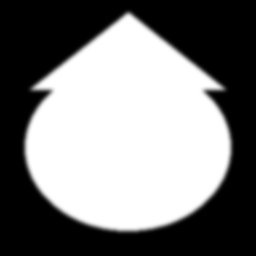

In [12]:
# create a strawberry-shaped mask at a chosen patch size in pixels
patch_size = 256  # patch resolution; adjust for printing DPI
def make_strawberry_mask(size):
    w, h = size, size
    mask = Image.new("L", (w,h), 0)
    draw = ImageDraw.Draw(mask)
    # simple heart/triangle+circle combo to approximate a strawberry shape
    # lower big rounded part - ellipse
    draw.ellipse([w*0.1, h*0.25, w*0.9, h*0.9], fill=255)
    # top triangle/point to form a strawberry tip
    draw.polygon([(w*0.5, h*0.05), (w*0.12, h*0.35), (w*0.88, h*0.35)], fill=255)
    # optional small leaf area: cut out a hole for leaf at top (we'll overlay separate leaf later)
    # draw.ellipse([w*0.36, h*0.0, w*0.64, h*0.26], fill=0)
    mask = mask.filter(ImageFilter.GaussianBlur(radius=2))
    return mask

mask_pil = make_strawberry_mask(patch_size)
mask_pil.save("strawberry_mask_preview.png")
mask_pil  # in Colab this will display


In [13]:
# preprocess for model input
preprocess = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],
                std=[0.229,0.224,0.225])
])

inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def pil_to_tensor(img):
    return T.ToTensor()(img).unsqueeze(0).to(device)

def apply_patch_to_image(img_pil, patch_tensor, mask_pil, position=(0,0), scale=1.0, angle=0.0):
    """
    img_pil: PIL RGB image
    patch_tensor: CxHxW (0..1) tensor on CPU (or GPU — will convert to image)
    mask_pil: PIL L mask at patch resolution
    position: (x,y) top-left where the patch is applied on img (in pixels of target image)
    scale: scale factor for patch size
    angle: rotation in degrees
    """
    img = img_pil.convert("RGBA")
    # convert patch tensor to PIL
    patch_np = (patch_tensor.clamp(0,1).cpu().numpy() * 255).astype(np.uint8)
    patch_pil = Image.fromarray(np.transpose(patch_np, (1,2,0)), mode="RGB").convert("RGBA")
    mask_resized = mask_pil.resize(patch_pil.size, resample=Image.BILINEAR)
    patch_pil.putalpha(mask_resized)

    # scale and rotate patch
    new_w = int(patch_pil.width * scale)
    new_h = int(patch_pil.height * scale)
    patch_pil = patch_pil.resize((new_w, new_h), Image.BILINEAR)
    patch_pil = patch_pil.rotate(angle, expand=True, resample=Image.BILINEAR)
    # reposition mask after rotation
    # paste with alpha
    x, y = position
    tmp = Image.new("RGBA", img.size)
    tmp.paste(patch_pil, (x,y), patch_pil)
    out = Image.alpha_composite(img, tmp).convert("RGB")
    return out


In [29]:
!mkdir -p source_images
!curl -L -o source_images/strawberry.jpg https://upload.wikimedia.org/wikipedia/commons/2/29/PerfectStrawberry.jpg
!curl -L -o source_images/apple.jpg https://upload.wikimedia.org/wikipedia/commons/1/15/Red_Apple.jpg
!curl -L -o source_images/cat.jpg https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg
!curl -L -o source_images/dog.jpg https://upload.wikimedia.org/wikipedia/commons/9/9a/Pug_600.jpg
!curl -L -o source_images/banana.jpg https://upload.wikimedia.org/wikipedia/commons/8/8a/Banana-Single.jpg
!curl -L -o source_images/cup.jpg https://upload.wikimedia.org/wikipedia/commons/4/45/A_small_cup_of_coffee.JPG

!curl -L -o source_images/strawberry2.jpg https://upload.wikimedia.org/wikipedia/commons/e/ef/Garden_strawberry_%28Fragaria_%C3%97_ananassa%29_halved.jpg
!curl -L -o source_images/strawberry3.jpg https://upload.wikimedia.org/wikipedia/commons/4/4c/Garden_strawberry_%28Fragaria_%C3%97_ananassa%29_single2.jpg

# Pineapples
!curl -L -o source_images/pineapple1.jpg https://upload.wikimedia.org/wikipedia/commons/c/cb/Pineapple_and_cross_section.jpg
!curl -L -o source_images/pineapple2.jpg https://upload.wikimedia.org/wikipedia/commons/3/3f/Pineapple-2540622.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  242k  100  242k    0     0  1128k      0 --:--:-- --:--:-- --:--:-- 1130k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  562k  100  562k    0     0  1975k      0 --:--:-- --:--:-- --:--:-- 1981k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  273k  100  273k    0     0  1088k      0 --:--:-- --:--:-- --:--:-- 1092k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 99389  100 99389    0     0   490k      0 --:--:-- --:--:-- --:--:--  492k
  % Total    % Received % Xferd  Average Speed   Tim

In [30]:
# Hyperparams
TARGET_CLASS = 953  # pineapple
batch_size = 8
num_steps = 1500
lr = 0.1
patch_res = patch_size
patch_res = 256

patch = torch.nn.Parameter(torch.rand(3, patch_res, patch_res, device=device) * 0.5 + 0.25)
optimizer = torch.optim.Adam([patch], lr=0.1)

# example dataset: use a small set of images to overlay on (you can load from your own directory)
# Place some source images in folder "source_images/" (jpg/png). These should be innocuous photos (people, objects).
from glob import glob
source_paths = glob("source_images/*.jpg") + glob("source_images/*.png")
assert len(source_paths) >= 8, "Put at least a few images in source_images/ for training."

def random_position_and_transform(img_w, img_h, patch_w, patch_h):
    # choose random scale/position/angle that makes sense
    scale = np.random.uniform(0.5, 1.2)
    angle = np.random.uniform(-30,30)
    # limit position so patch is fully on image
    new_w = int(patch_w * scale)
    new_h = int(patch_h * scale)
    x = np.random.randint(0, max(1, img_w - new_w))
    y = np.random.randint(0, max(1, img_h - new_h))
    return (x,y), scale, angle

loss_fn = nn.CrossEntropyLoss()

print("Starting training...")
for step in tqdm(range(num_steps)):
    # sample a batch of source images
    batch_paths = np.random.choice(source_paths, batch_size, replace=True)
    images_tensor = []
    for p in batch_paths:
        img = Image.open(p).convert("RGB")
        iw, ih = img.size
        (x,y), scale, angle = random_position_and_transform(iw, ih, patch_res, patch_res)
        # apply the patch with small random color jitter
        patched_pil = apply_patch_to_image(img, patch.detach(), mask_pil, position=(x,y), scale=scale, angle=angle)
        # apply small random photometric changes for EOT
        jitter = T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02)
        patched_pil = jitter(patched_pil)
        img_tensor = preprocess(patched_pil).to(device)
        images_tensor.append(img_tensor)
    images = torch.stack(images_tensor).to(device)
    target = torch.full((images.size(0),), TARGET_CLASS, dtype=torch.long, device=device)

    logits = model(images)
    loss = loss_fn(logits, target)

    optimizer.zero_grad()
    loss.backward()
    # gradient step on patch param
    optimizer.step()

    # clamp patch to [0,1]
    with torch.no_grad():
        patch.clamp_(0.0, 1.0)

    # optional: decay lr or print stats
    if (step+1) % 100 == 0:
        preds = logits.argmax(dim=1)
        acc = (preds == target).float().mean().item()
        print(f"Step {step+1}/{num_steps}  loss={loss.item():.4f}  acc={acc:.3f}")


Starting training...


  0%|          | 0/1500 [00:00<?, ?it/s]/var/folders/rn/5rl0r6jn4ws28cl_m7v_mf7h0000gn/T/ipykernel_70006/1516186588.py:29: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  patch_pil = Image.fromarray(np.transpose(patch_np, (1,2,0)), mode="RGB").convert("RGBA")
  4%|▍         | 60/1500 [03:13<1:17:19,  3.22s/it]


KeyboardInterrupt: 

In [ ]:
# Save patch image (apply mask to reveal strawberry shape)
final_patch_np = (patch.detach().cpu().numpy().transpose(1,2,0) * 255).astype(np.uint8)
final_patch_pil = Image.fromarray(final_patch_np, "RGB")
# apply mask to make transparent background where mask=0
alpha = make_strawberry_mask(patch_res)
final_rgba = final_patch_pil.convert("RGBA")
final_rgba.putalpha(alpha)
final_rgba.save("final_strawberry_patch.png")
print("Saved final_strawberry_patch.png — download and print at 300 DPI for best results.")
final_rgba


In [ ]:
test_paths = glob("test_images/*.jpg") + glob("test_images/*.png")
for p in test_paths[:10]:
    img = Image.open(p).convert("RGB")
    iw, ih = img.size
    (x,y), scale, angle = random_position_and_transform(iw, ih, patch_res, patch_res)
    patched_pil = apply_patch_to_image(img, patch.detach(), mask_pil, position=(x,y), scale=scale, angle=angle)
    input_t = preprocess(patched_pil).unsqueeze(0).to(device)
    logits = model(input_t)
    pred = logits.argmax(dim=1).item()
    print("File:", p, "=> predicted:", imagenet_classes[pred])
    display(patched_pil.resize((300,300)))
